In [1]:
# !pip install pythainlp
# !pip install stop_words

In [2]:
import pythainlp
from pythainlp import word_tokenize
from pythainlp.corpus import wordnet
from pythainlp.corpus import thai_stopwords

import nltk
from nltk.stem.porter import PorterStemmer
from nltk.corpus import words

from stop_words import get_stop_words
import pandas as pd

nltk.download('words')
th_stop = tuple(thai_stopwords())
en_stop = tuple(get_stop_words('en'))
p_stemmer = PorterStemmer()

import re
import string



[nltk_data] Downloading package words to /Users/nat/nltk_data...
[nltk_data]   Package words is already up-to-date!


In [3]:

def clean_msg(msg):
    # ลบ text ที่อยู่ในวงเล็บ <> ทั้งหมด
    msg = re.sub(r'<.*?>','', msg)
    
    # ลบ hashtag
    msg = re.sub(r'#','',msg)
    msg = msg.replace('ชิมช็อปใช้เฟส', '')    
    
    msg = msg.replace('ลทบ', 'ลงทะเบียน')   

    msg = msg.replace('ชิมช็อปใช้', '')        
    msg = msg.replace('ชิมช็อป', '')

    
    # ลบ เครื่องหมายคำพูด (punctuation)
    for c in string.punctuation:
        msg = re.sub(r'\{}'.format(c),'',msg)
    
    # ลบ separator เช่น \n \t
    msg = ' '.join(msg.split())
    
    return msg

In [4]:
def split_word(text):
    tokens = word_tokenize(text,engine='newmm')
    
    # Remove stop words ภาษาไทย และภาษาอังกฤษ
    tokens = [i for i in tokens if not i in th_stop and not i in en_stop]
    
    # หารากศัพท์ภาษาไทย และภาษาอังกฤษ
    # English
    tokens = [p_stemmer.stem(i) for i in tokens]
    
    # Thai
    tokens_temp=[]
    for i in tokens:
        w_syn = wordnet.synsets(i)
        if (len(w_syn)>0) and (len(w_syn[0].lemma_names('tha'))>0):
            tokens_temp.append(w_syn[0].lemma_names('tha')[0])
        else:
            tokens_temp.append(i)
    
    tokens = tokens_temp
    
    # ลบตัวเลข
    tokens = [i for i in tokens if not i.isnumeric()]
    
    # ลบช่องว่าง
    tokens = [i for i in tokens if not ' ' in i]

    return tokens

In [5]:
split_word("สวัสดีจ้าแมวสุนัขหมา")

['สวัสดี', 'แมว', 'สุนัข', 'หมา']

In [6]:
!pwd

/Users/nat/0000_DataScienceJupyter/000A/notebooks/hw-nlp


In [7]:
tweets = pd.read_csv('shop.csv',encoding="utf8", header=None)

In [8]:
tweets.describe()

,0
count,1228
unique,1226
top,รับลงค่ะ #ชิมช็อปใช้เฟส2
freq,2


In [9]:
tweets.head()

,0
0,ตื่นตี5:30มันวันหยุดกูกูกดเข้าระบบตั้งแต่5:55แ...
1,#ชิมช็อปใช้เฟส2 มึงมาประกาศรับลงทะเบียนให้ แล...
2,เข้าได้รอบเดียว คือทำได้ต่อยาว เช้านี้10คน หมด...
3,เต็มแล้วจ้าาา ตื่นมาทำไรตั้งแต่ตี 5 😂😂 #ชิมช็อ...
4,เก็บเงินค่าซื้อหวยแต่ละเดือนได้มากกว่าชิมช้อปใ...


In [10]:
# t=tweets[0]
data = []
clean_text = [clean_msg(str(txt)) for txt in tweets[0]]
for tweet in clean_text:
    data.append(split_word(str(tweet)))
tokens_list = data

In [11]:
# clean_text

In [12]:
from sklearn.feature_extraction.text import CountVectorizer

tokens_list_j = [','.join(tkn) for tkn in tokens_list]
cvec = CountVectorizer(analyzer=lambda x:x.split(','))
c_feat = cvec.fit_transform(tokens_list_j)

# c_feat
# cvec.vocabulary_
# tokens_list_j

In [13]:
from sklearn.feature_extraction.text import TfidfVectorizer
tvec = TfidfVectorizer(analyzer=lambda x:x.split(','),)
t_feat = tvec.fit_transform(tokens_list_j)

# t_feat.toarray()
# tvec.get_feature_names()
# t_feat[:,:5].todense()
# len(tvec.idf_)

In [14]:
#!pip install gensim

In [15]:
from gensim.models import Word2Vec

In [16]:
model = Word2Vec(tokens_list, min_count=1)
sim_words=model.wv.similar_by_word('แม่')
print(sim_words)

[('ไม่ได้', 0.9893267154693604), ('คน', 0.9872778654098511), ('กด', 0.9862289428710938), ('รอ', 0.9853548407554626), ('คนอื่น', 0.9833321571350098), ('\u200b', 0.9830180406570435), ('ทำ', 0.9827907681465149), ('เว็บ', 0.980774998664856), ('อิ', 0.9804444313049316), ('ข้อมูล', 0.9802520275115967)]


In [17]:
from sklearn.cluster import KMeans

n_clusters = 4

kmeans = KMeans(n_clusters=n_clusters, init='k-means++', max_iter=300, n_init=10, random_state=0)
pred_y = kmeans.fit_predict(t_feat)


In [18]:
pd.DataFrame(pred_y).describe()

,0
count,1228.000000
mean,0.375407
std,0.819454
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,3.000000


In [19]:
summary = {}
for idx,tweet in enumerate(tokens_list):
    predicted_val = pred_y[idx]
    if predicted_val not in summary.keys():
        summary[predicted_val] = []
    summary[predicted_val] += [tweet]
    
    print("CLASS={} TWEET={}".format(predicted_val, ','.join(tweet)))

CLASS=0 TWEET=ตื่น,ตี,วันหยุด,กด,ระบบ,ทำ,แต่วัน,เฟส,เฟส,รอบ,เช้า,รอบ,เย็น,เวลานี้,เต็ม,ด้าย,พี่น้อง,ฝาก,เทียว,ถาม,หัว,ร้อน,เลือก,คน,เหรอ,วะ,ทำ,เลือก,ล่ะ,หัว,ร้อน,ว้อย,ย
CLASS=0 TWEET=ประกาศรับ,ลงทะเบียน,คนอื่น,ไม่ได้,ลูก,ดี,กาล,วิ่ง,นิ,นั่ง,ไถ,โทร,แล้วก็,ออกจาก,หน้า,เวป,ดิ
CLASS=0 TWEET=รอบ,ทำได้,เช้านี้,คน,ห่วง,สักที,ไอ,บ้า,😂
CLASS=3 TWEET=เต็ม,าา,ตื่น,ทำ,ตี,😂😂
CLASS=2 TWEET=เก็บเงิน,ค่า,ซื้อ,หวย,เดือน,ชิม,ช้อป
CLASS=0 TWEET=ว่ะ,งง
CLASS=3 TWEET=รอบ,เช้า,เต็ม,รอบ,เย็น,คิว,ว่าง,นะคะ,​
CLASS=1 TWEET=ระบบ,ขี้โกง,พวกเรา,รอ,คิว,คน,ลงทะเบียน,ไม่ต้อง,รอ,คิว,ในขณะที่,​คนรอ,รอ,ต่อไป
CLASS=0 TWEET=แนะนำ,เนต,บ้าน,เนต,โทร,พิชิต,อ่ะ,แน่,ร้าน,เนต,แรง,ร้าน,เนต,ชัว
CLASS=0 TWEET=ตอนเย็น,เจอกัน
CLASS=3 TWEET=เช้านี้,เต็ม,แสน,ไว
CLASS=0 TWEET=ท้อ,​
CLASS=3 TWEET=เช้า,ฝดใฝ,ฉุด,ฉุด,เต็ม
CLASS=0 TWEET=ข้อ,ความใน,โทร,ไม่สำเร็จ,พอดู,เมลล์,อะ,สำเร็จ,นึง,ไม่สำเร็จ,นึง,เมลล์,หนู,อี,น,ไห,นคะ
CLASS=0 TWEET=เสียเวลา,อิ,ห่า,ตี,ตี,เเปด,น.,ไม่ได้,แม่,ดุ,แน่
CLASS=0 TWEET=หวย,ใช้ไม่ได้,อ่า
CLASS=0 TWEET=น,สิทธิ์,เช้า

In [20]:
tweets.head()

,0
0,ตื่นตี5:30มันวันหยุดกูกูกดเข้าระบบตั้งแต่5:55แ...
1,#ชิมช็อปใช้เฟส2 มึงมาประกาศรับลงทะเบียนให้ แล...
2,เข้าได้รอบเดียว คือทำได้ต่อยาว เช้านี้10คน หมด...
3,เต็มแล้วจ้าาา ตื่นมาทำไรตั้งแต่ตี 5 😂😂 #ชิมช็อ...
4,เก็บเงินค่าซื้อหวยแต่ละเดือนได้มากกว่าชิมช้อปใ...


In [21]:
clusters_text = [ pd.DataFrame(tweets[pred_y == c]) for c in range(n_clusters)]

In [22]:
# q = clusters

In [23]:
# for i in range(n_clusters):
#     print("class={}".format(i))
#     print("--------------")    
#     g[i] = (tweets[pred_y == i])
#     print("--------------")

In [24]:
# x = pd.DataFrame(g)

In [25]:
# g[1]

In [26]:
# q[1]

In [27]:
def plot(embeddings, labels):
  assert embeddings.shape[0] >= len(labels), 'More labels than embeddings'
  pylab.figure(figsize=(15,15))  # in inches
  for i, label in enumerate(labels):
    x, y = embeddings[i,:]
    pylab.scatter(x, y)
    pylab.annotate(label, xy=(x, y), xytext=(5, 2), textcoords='offset points',
                   ha='right', va='bottom')
  pylab.show()

# words = [reverse_dictionary[i] for i in range(1, num_points+1)]
# plot(two_d_embeddings, words)

In [28]:
def clustering_on_wordvecs(word_vectors, num_clusters):
    # Initalize a k-means object and use it to extract centroids
    kmeans_clustering = KMeans(n_clusters = num_clusters, init='k-means++');
    idx = kmeans_clustering.fit_predict(word_vectors);
    
    return kmeans_clustering.cluster_centers_, idx;

In [29]:
# Z = model.wv.vectors

In [30]:
# centers, clusters = clustering_on_wordvecs(Z, 20);

In [31]:
# centers, clusters = clustering_on_wordvecs(Z, 4);

In [32]:
# pd.DataFrame(clusters).describe()

In [33]:
# labels = model.wv.index2word

In [34]:
# pred_y

In [35]:
import matplotlib.pyplot as plt # วาดรูป
from pythainlp.tokenize import word_tokenize # ตัดคำไทย
from wordcloud import WordCloud # สร้าง Wordcloud

In [36]:
yyyy = pd.DataFrame(tokens_list)

cls = []
cls.append(yyyy[pred_y == 0])
cls.append(yyyy[pred_y == 1])
cls.append(yyyy[pred_y == 2])
cls.append(yyyy[pred_y == 3])

cls[1].iloc[: 1]


,0,1,2,3,4,5,6,7,8,9,...,33,34,35,36,37,38,39,40,41,42
7,ระบบ,ขี้โกง,พวกเรา,รอ,คิว,คน,ลงทะเบียน,ไม่ต้อง,รอ,คิว,...,None,None,None,None,None,None,None,None,None,None


In [37]:
# cls[1].iloc[: 1].dropna(axis=1).values
cls[1].head()


,0,1,2,3,4,5,6,7,8,9,...,33,34,35,36,37,38,39,40,41,42
7,ระบบ,ขี้โกง,พวกเรา,รอ,คิว,คน,ลงทะเบียน,ไม่ต้อง,รอ,คิว,...,None,None,None,None,None,None,None,None,None,None
24,แม่,รอ,งง,งง,เห้ยยคน,ตัง,คน,เฒ่า,คนแก่,อยาก,...,None,None,None,None,None,None,None,None,None,None
32,หน้า,รอ,คิว,แนะนำ,วิธี,😂,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
66,ไม่ได้,หรอก,อี,คน,ระบบ,อะ,เข้าไป,กด,คน,ไม่ได้,...,None,None,None,None,None,None,None,None,None,None
67,แบงค์,ป่ะ,บอ,รอ,กี่,คิว,รอ,เคว้งคว้าง,าาาาา,None,...,None,None,None,None,None,None,None,None,None,None


In [38]:
flatten = lambda l: [item for sublist in l for item in sublist]

l_cls0 = [x.dropna().values for i,x in cls[0].iterrows()]
l_cls1 = [x.dropna().values for i,x in cls[1].iterrows()]
l_cls2 = [x.dropna().values for i,x in cls[2].iterrows()]
l_cls3 = [x.dropna().values for i,x in cls[3].iterrows()]

# print(flatten(l_cls0))

In [39]:
tweets.head()

,0
0,ตื่นตี5:30มันวันหยุดกูกูกดเข้าระบบตั้งแต่5:55แ...
1,#ชิมช็อปใช้เฟส2 มึงมาประกาศรับลงทะเบียนให้ แล...
2,เข้าได้รอบเดียว คือทำได้ต่อยาว เช้านี้10คน หมด...
3,เต็มแล้วจ้าาา ตื่นมาทำไรตั้งแต่ตี 5 😂😂 #ชิมช็อ...
4,เก็บเงินค่าซื้อหวยแต่ละเดือนได้มากกว่าชิมช้อปใ...


In [40]:
def wordCloud(lst):
    wordcloud = WordCloud(font_path='THSarabunNew.ttf',
         background_color="white",
                      width=1600, # กว้าง
                      	height=900, # ยาว
                      	collocations=False,
                      regexp=r"[\u0E00-\u0E7Fa-zA-Z']+"
                      ).generate(' '.join(lst))
    plt.imshow(wordcloud, cmap=plt.cm.gray, interpolation='bilinear')
    plt.axis("off")
    plt.show()

In [41]:
# flatten(l_cls0)

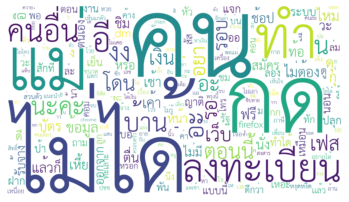

In [42]:
wordCloud(flatten(l_cls0))


In [43]:
# cls[0]

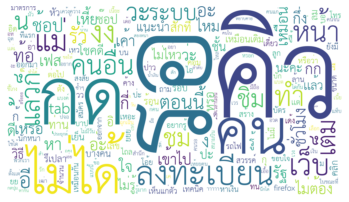

In [44]:
# class 2 รอ
wordCloud(flatten(l_cls1))

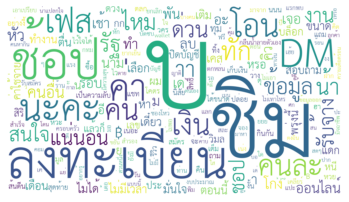

In [45]:
#class 3 ลงทะเบียน
wordCloud(flatten(l_cls2))

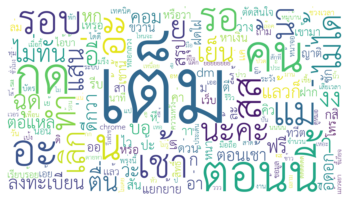

In [46]:
#class 4 เต็ม
wordCloud(flatten(l_cls3))